**Imports**

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import sys

sys.path.append('C:\\Coding\\customer-churn-prediction\\src')
from utils import download_telco_churn_dataset, split_test_train
from preprocessing import get_preproc

RND_SEED = 42

**Getting Preprocessing and Data**

In [2]:
telco = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X_train, X_test, y_train, y_test = split_test_train(telco)

preprocessing = get_preproc()

# Models

**Help Function**

Функция для оценки различных моделей на тестовой и тернировочных данных.

In [3]:
from sklearn.utils import class_weight

def fit_and_evaluate(models, cv=10, verbose=0):
    # Крафтим пайплайны для каждой модели
    pipelines = {}

    for name, model in models:
        pipelines[name] = (ImbPipeline([
            ("preproc", preprocessing.named_steps['preproc']),
            ("drop", preprocessing.named_steps['drop']),
            ("smote", preprocessing.named_steps['smote']),
            ("model", model)
        ]))

    metrics = {}

    # Оценивать модели будем по roc_auc score
    for name, model in pipelines.items():
        # Оценим сырые модельки на CV
        roc_auc_cv = cross_val_score(
            model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()

        model.fit(X_train, y_train)
        
        print(len(model[:-1].get_feature_names_out()))

        y_pred_test = model.predict(X_test)

        # Metrics evaluating
        roc_auc_test = roc_auc_score(y_test, y_pred_test)
        
        if verbose == 1:
            print(f"MODEL ({name}):\nroc_auc_test: {roc_auc_test}\nroc_auc_cv: {roc_auc_cv}\n")

        metrics[name] = {
            'roc_auc_test': roc_auc_test,
            'roc_auc_cv': roc_auc_cv,
        }

    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda item: -item[1]['roc_auc_cv']))

    print(f"ТОП МОДЕЛЕЙ по ROC-AUC:")
    for name, metric in sorted_metrics.items():
        print(
            "\n" + f"{name} : \nAUC: {metric['roc_auc_cv']}")

## Models Comparation

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lgbm = LGBMClassifier(objective='binary', random_state=RND_SEED, verbose=-1)

knn = KNeighborsClassifier(n_neighbors=5)

cb = CatBoostClassifier()

lr = LogisticRegression(random_state=RND_SEED, penalty='l2')

lin_svc = LinearSVC(C=1, random_state=RND_SEED)

gb = GradientBoostingClassifier(random_state=RND_SEED)

svc = SVC(C=1, random_state=RND_SEED)

rnd_forest = RandomForestClassifier(random_state=RND_SEED, n_jobs=-1)

xgb = XGBClassifier(random_state=RND_SEED, n_jobs=-1)

models = [
    ("Logistic Regression L2", lr),
    ("LightGBM", lgbm),
    ("RND Forest", rnd_forest),
    ("XGB Classifier", xgb),
    ("Gradient Boosting", gb),
    ("Linear SVC", lin_svc),
    ("SVC", svc),
    ("CatBoost", svc),
    ("KNC", svc),
]

In [5]:
fit_and_evaluate(models, verbose=1)

20
MODEL (Logistic Regression L2):
roc_auc_test: 0.7515810276679842
roc_auc_cv: 0.8416992543427979

20
MODEL (LightGBM):
roc_auc_test: 0.7408302978635459
roc_auc_cv: 0.8285989156151476

20
MODEL (RND Forest):
roc_auc_test: 0.734674106796869
roc_auc_cv: 0.8161306314227458

20
MODEL (XGB Classifier):
roc_auc_test: 0.7403136221550545
roc_auc_cv: 0.8203668519786362

20
MODEL (Gradient Boosting):
roc_auc_test: 0.7603554728874421
roc_auc_cv: 0.8415803617566191

20
MODEL (Linear SVC):
roc_auc_test: 0.7479410473016611
roc_auc_cv: 0.8406361721501515

20
MODEL (SVC):
roc_auc_test: 0.7482110103593479
roc_auc_cv: 0.8163840264777142

20
MODEL (CatBoost):
roc_auc_test: 0.7482110103593479
roc_auc_cv: 0.8163840264777142

20
MODEL (KNC):
roc_auc_test: 0.7482110103593479
roc_auc_cv: 0.8163840264777142

ТОП МОДЕЛЕЙ по ROC-AUC:

Logistic Regression L2 : 
AUC: 0.8416992543427979

Gradient Boosting : 
AUC: 0.8415803617566191

Linear SVC : 
AUC: 0.8406361721501515

LightGBM : 
AUC: 0.8285989156151476

XGB Cl

Непосредственно в этой задаче мне важен `Recall` на положительном класса, то есть процент верно определенных `Churn`.

## LightGBM + GB + Logist Regr

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint


def fine_tuning_models(models_data):
    for name, model_data in models_data.items():
        models_data[name] = {
            "pipeline": ImbPipeline([
                ("preproc", preprocessing.named_steps['preproc']),
                ("drop", preprocessing.named_steps['drop']),
                ("smote", preprocessing.named_steps['smote']),
                ("model", model_data["model"]),
            ]),
            "param_distrib": model_data["param_disturb"],
        }

        roc_auc_losses = cross_val_score(
            models_data[name]["pipeline"], X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
        print(f'{name} ROC-AUC:\n{pd.Series(roc_auc_losses).mean()}')

    print('=' * 50 + "Tuned models!!!" + '=' * 50)

    best_models = {}
    n_iter = 50

    for name, model_data in models_data.items():
        if name == "Logistic Regression":
            n_iter = 200
        rnd_search = RandomizedSearchCV(model_data["pipeline"], param_distributions=model_data["param_distrib"],
                                        n_iter=n_iter, cv=5, n_jobs=-1, random_state=RND_SEED, scoring='roc_auc')
        rnd_search.fit(X_train, y_train)

        roc_auc_losses_cv = rnd_search.best_score_

        print(f'{name} AUC:\n{pd.Series(roc_auc_losses_cv).mean()}')

        best_models[name] = rnd_search.best_estimator_

    return best_models

In [ ]:
pd_lgbm = {
    'model__n_estimators': [100, 200, 500, 1000, 2000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100, 200],
    'model__min_child_samples': [10, 20, 30],
    'model__max_depth': [3, 5, 7, -1],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
}

pd_gb = {
    "model__learning_rate": loguniform(0.01, 0.3),
    "model__n_estimators": randint(50, 500),
    "model__max_depth": randint(2, 8),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 15),
    "model__max_features": ['sqrt', 'log2', None, 0.8],
    "model__subsample": uniform(0.7, 0.3),
}

pd_lr = [
    {
        # L2 регуляризация - основной вариант
        "model__penalty": ['l2', 'l1'],
        "model__C": loguniform(0.001, 100),
        "model__solver": ['liblinear', 'saga'],
        "model__max_iter": randint(200, 2000),
        "model__tol": loguniform(1e-5, 1e-3),
    },
    {
        # ElasticNet
        "model__penalty": ['elasticnet'],
        "model__C": loguniform(0.001, 100),
        "model__l1_ratio": uniform(0.1, 0.8),  # Баланс между L1 и L2
        "model__solver": ['saga'],
        "model__max_iter": randint(300, 2000),
        "model__tol": loguniform(1e-5, 1e-3),
    },
    {
        # Без регуляризации
        "model__penalty": [None],
        "model__solver": ['lbfgs', 'newton-cg'],
        "model__max_iter": randint(100, 1000),
        "model__tol": loguniform(1e-5, 1e-3),
    }
]

models_data = {
    "Logistic Regression": {
        "model": lr,
        "param_disturb": pd_lr,
    },
    "Gradient Boosting": {
        "model": gb,
        "param_disturb": pd_gb,
    },
    "LightGBM": {
        "model": lgbm,
        "param_disturb": pd_lgbm,
    },
}

In [51]:
best_models = fine_tuning_models(models_data)

# Logistic Regression ROC-AUC:
# 0.8416992543427979
# Gradient Boosting ROC-AUC:
# 0.8415803617566191
# LightGBM ROC-AUC:
# 0.8285989156151476
# ==================================================Tuned models!!!==================================================
# Logistic Regression AUC:
# 0.8415815502945746
# Gradient Boosting AUC:
# 0.8442431662936801
# LightGBM AUC:
# 0.8431492546787313

Logistic Regression ROC-AUC:
0.8416992543427979
Gradient Boosting ROC-AUC:
0.8415803617566191
LightGBM ROC-AUC:
0.8285989156151476
==================================================Tuned models!!!==================================================
Logistic Regression AUC:
0.8416824753395545
Gradient Boosting AUC:
0.8445973397628093
LightGBM AUC:
0.8431492546787313


Тут лучше всего себя показал град бустинг!

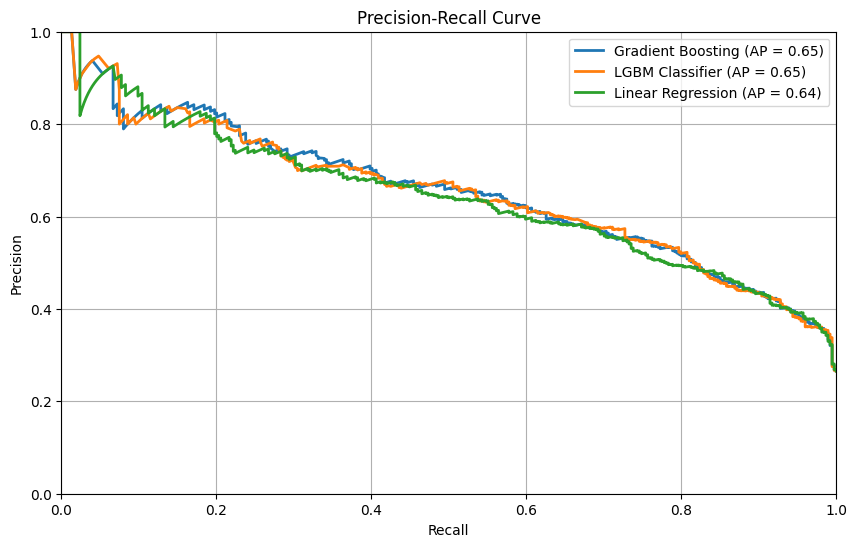

In [57]:
gb_tuned = best_models["Gradient Boosting"]
lr_tuned = best_models["Logistic Regression"]
lgbm_tuned = best_models["LightGBM"]

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Gradient Boosting (AP = {average_precision:.2f})')

y_scores = lgbm_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'LGBM Classifier (AP = {average_precision:.2f})')

y_scores = lr_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'Linear Regression (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [58]:
def get_optimal_threshold(model, target='f1', target_score=0.8, help_metric='recall', help_metric_min_score=0.7):
    from sklearn.metrics import precision_recall_curve
    
    if (target not in ['f1', 'precision', 'recall']):
        raise ValueError("target must be 'f1', 'precision' or 'recall'.")
    
    if (help_metric not in ['precision', 'recall']):
        raise ValueError("target must be 'precision' or 'recall'.")
    
    def f1(precision_, recall_):
        if precision_ + recall_ == 0:
            return 0.0
        
        return 2 * (precision_ * recall_) / (precision_ + recall_)
    
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    f1s = []
    max_f1_score = 0
    max_f1_idx = 0

    for i in range(len(thresholds)):
        f1s.append(f1(precision[i], recall[i]))
        if max_f1_score < f1s[i]:
            if (help_metric is None):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'recall') and (recall[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'precision') and (precision[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i

    optimal_idx_recall = np.argmin(recall >= target_score)
    optimal_idx_precision = np.argmin(recall >= target_score)
    optimal_threshold_recall = thresholds[optimal_idx_recall]
    optimal_threshold_precision = thresholds[optimal_idx_precision]
    optimal_threshold_f1 = thresholds[max_f1_idx]

    if target == 'f1':
        return optimal_threshold_f1
    elif target == 'recall':
        return optimal_threshold_recall
    elif target == 'precision':
        return optimal_threshold_precision

In [66]:
from sklearn.model_selection import FixedThresholdClassifier

optimal_threshold_LR = get_optimal_threshold(model=lr_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
optimal_threshold_GB = get_optimal_threshold(model=gb_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
optimal_threshold_LGBM = get_optimal_threshold(model=lgbm_tuned, target='f1', help_metric='recall', help_metric_min_score=0.8)
 
lr_tuned = FixedThresholdClassifier(lr_tuned, threshold=optimal_threshold_LR)
lr_tuned.fit(X_train, y_train)
gb_tuned = FixedThresholdClassifier(gb_tuned, threshold=optimal_threshold_GB)
gb_tuned.fit(X_train, y_train)
lgbm_tuned = FixedThresholdClassifier(lgbm_tuned, threshold=optimal_threshold_LGBM)
lgbm_tuned.fit(X_train, y_train)


y_pred_otimised_LR = lr_tuned.predict(X_test)
y_pred_otimised_GB = gb_tuned.predict(X_test)
y_pred_otimised_LGBM = lgbm_tuned.predict(X_test)

In [67]:
print(f'LR THRESHOLD: {optimal_threshold_LR}')
print(f'F1: {f1_score(y_test, y_pred_otimised_LR)}')
print(f'P: {precision_score(y_test, y_pred_otimised_LR)}')
print(f'R: {recall_score(y_test, y_pred_otimised_LR)}')
print()
print(f'GB THRESHOLD: {optimal_threshold_GB}')
print(f'F1: {f1_score(y_test, y_pred_otimised_GB)}')
print(f'P: {precision_score(y_test, y_pred_otimised_GB)}')
print(f'R: {recall_score(y_test, y_pred_otimised_GB)}')
print()
print(f'LGBM THRESHOLD: {optimal_threshold_LGBM}')
print(f'F1: {f1_score(y_test, y_pred_otimised_LGBM)}')
print(f'P: {precision_score(y_test, y_pred_otimised_LGBM)}')
print(f'R: {recall_score(y_test, y_pred_otimised_LGBM)}')

# THRESHOLD: 0.4636498354792728
# F1: 0.6237006237006237
# P: 0.5102040816326531
# R: 0.8021390374331551

LR THRESHOLD: 0.4368648433167882
F1: 0.6140350877192983
P: 0.4831288343558282
R: 0.8422459893048129

GB THRESHOLD: 0.4613800439007874
F1: 0.6291666666666667
P: 0.515358361774744
R: 0.8074866310160428

LGBM THRESHOLD: 0.4828453809384702
F1: 0.634453781512605
P: 0.5224913494809689
R: 0.8074866310160428


# Ансамблирование лучших моделей

Возьму только две лучшие модели - Gradient Boosting, Logistic Regression.

In [83]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict

final_system = VotingClassifier(estimators=[('lr', lr_tuned), ('gb', gb_tuned), ('svc', lgbm_tuned)], voting='soft')

y_pred_lgbm = cross_val_predict(lgbm_tuned, X_train, y_train, cv=10, n_jobs=-1)
y_pred_final = cross_val_predict(final_system, X_train, y_train, cv=10, n_jobs=-1)

print(f'MODEL: LGBM')
print(f'F1: {f1_score(y_train, y_pred_lgbm)}')
print(f'P: {precision_score(y_train, y_pred_lgbm)}')
print(f'R: {recall_score(y_train, y_pred_lgbm)}')
print(f'AUC: {roc_auc_score(y_train, y_pred_lgbm)}')
print()
print(f'MODEL: ENSEMBLE')
print(f'F1: {f1_score(y_train, y_pred_final)}')
print(f'P: {precision_score(y_train, y_pred_final)}')
print(f'R: {recall_score(y_train, y_pred_final)}')
print(f'AUC: {roc_auc_score(y_train, y_pred_final)}')

MODEL: LGBM
F1: 0.6324028176363162
P: 0.5183917878528657
R: 0.8107023411371237
AUC: 0.7693279765603473

MODEL: ENSEMBLE
F1: 0.6320855614973262
P: 0.5265033407572383
R: 0.7906354515050167
AUC: 0.7669050656896913


Метрики не улучшились => оставлю LighnGBM.

# Визуализация ошибок модели (LR)

In [69]:
y_pred_test = final_system.predict(X_test)

c:\Coding\customer-churn-prediction\.venv\Lib\site-packages\imblearn\pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


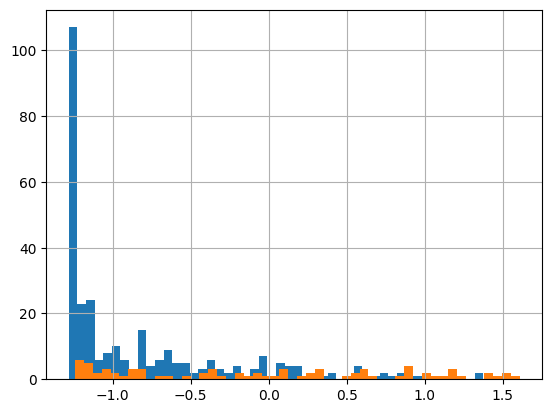

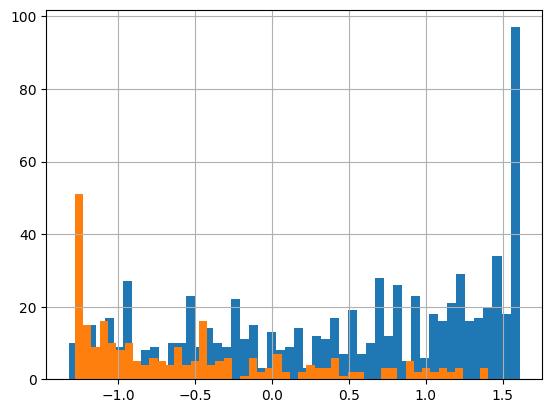

In [70]:
X_test_preprocessed = preprocessing[:-1].transform(X_test)

false_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 1)
]
true_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 1)
]
false_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 0)
]
true_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 0)
]

col = "num__tenure"
true_positive[col].hist(bins=50)
false_negative[col].hist(bins=50)
plt.show()

true_negative[col].hist(bins=50)
false_positive[col].hist(bins=50)
plt.show()

In [71]:
# Добавим метки для каждого типа предсказания
X_test_with_errors = preprocessing[:-1].transform(X_test)
X_test_with_errors['true_label'] = y_test
X_test_with_errors['predicted_label'] = y_pred_test
X_test_with_errors['error_type'] = 'correct'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 1), 'error_type'] = 'false_negative'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 0), 'error_type'] = 'false_positive'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 1), 'error_type'] = 'true_positive'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 0), 'error_type'] = 'true_negative'

# Сравним средние значения признаков по группам
error_summary = X_test_with_errors.groupby('error_type').mean().T
print(error_summary)

error_type                                     false_negative  false_positive  \
num__MonthlyCharges                                  0.047013        0.282800   
num__tenure                                         -0.034743       -0.536939   
num__MonthlyCharges tenure                           0.124681       -0.273651   
sqrt__TotalCharges                                   0.117376       -0.275658   
yes_no__Partner                                      0.513158        0.332075   
yes_no__Dependents                                   0.368421        0.124528   
yes_no__OnlineSecurity                               0.473684        0.128302   
yes_no__TechSupport                                  0.460526        0.162264   
yes_no__StreamingTV                                  0.473684        0.388679   
yes_no__PaperlessBilling                             0.592105        0.709434   
1hot__InternetService_DSL                            0.447368        0.237736   
1hot__InternetService_Fiber 

c:\Coding\customer-churn-prediction\.venv\Lib\site-packages\imblearn\pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


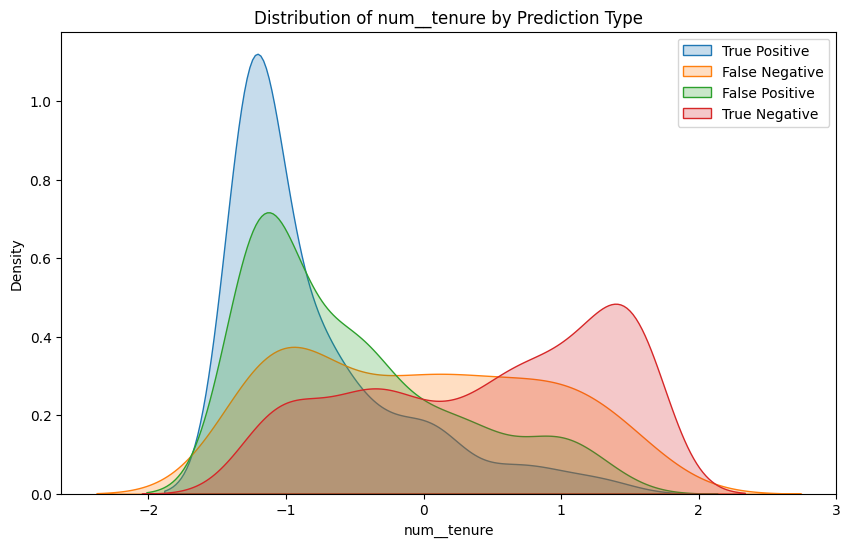

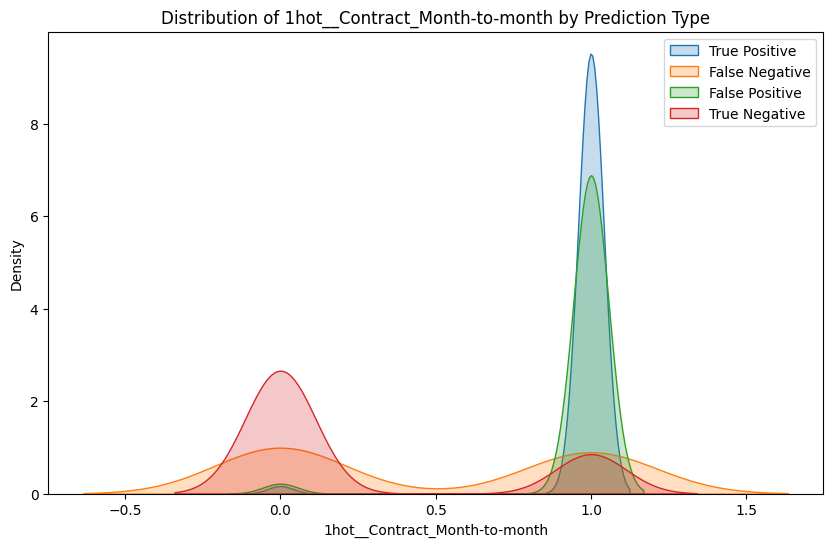

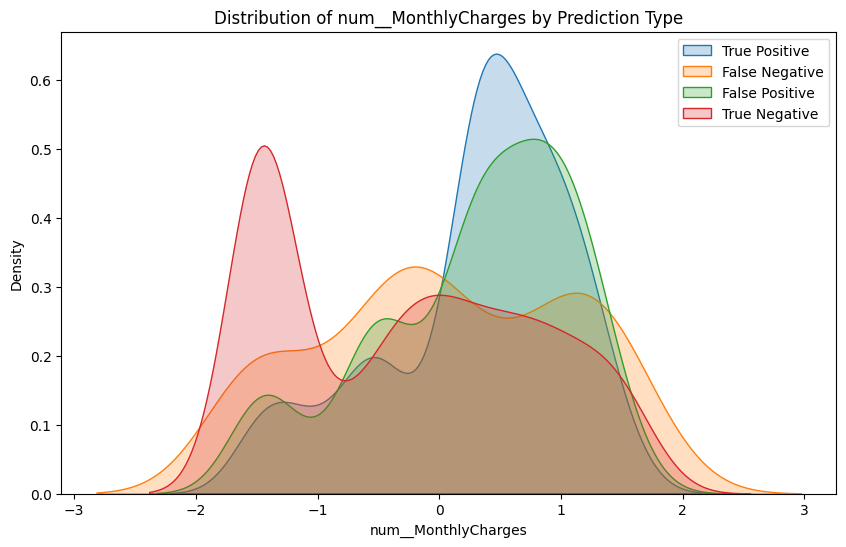

In [72]:
# Выберем несколько наиболее важных признаков (если знаете)
# Или проанализируйте все по очереди
important_features = ['num__tenure', '1hot__Contract_Month-to-month', 'num__MonthlyCharges'] # замените на ваши
import seaborn as sns

for feature in important_features:
    plt.figure(figsize=(10, 6))
    
    # Сравним распределения для разных типов ошибок
    sns.kdeplot(data=true_positive[feature], label='True Positive', fill=True)
    sns.kdeplot(data=false_negative[feature], label='False Negative', fill=True)
    sns.kdeplot(data=false_positive[feature], label='False Positive', fill=True)
    sns.kdeplot(data=true_negative[feature], label='True Negative', fill=True)
    
    plt.title(f'Distribution of {feature} by Prediction Type')
    plt.legend()
    plt.show()

Из графиков не понятно, почему наша модель ошибается. Скорее всего из-за линейной неразделимости классов.